# Accumulating padding

* https://adventofcode.com/2022/day/10

As is often the case with AoC puzzles, the story makes this sound harder than it is, at least for part 1. All we need to do is add some padding. `addx` instructions take two cycles to complete, so we can insert a `noop` before it to account for the extra cycle. And since we need to know the values *during* a cycle, to get the value of the `X` register during cycle $n$, execute the first $n - 1$ instructions. Or, both to accomodate for 0-based indexing and the off-by one nature of the puzzle, start with two extra `noop` instructions. Last but not least, a `noop` is exactly the same thing as adding `0` in that step, letting us replace *all* instructions with the delta for `X` in that cycle, and prime the sequence with `1`, `0` to give `X` its starting value.

So, the first small program example given:

```
noop
addx 3
addx -5
```

can be transformed to the following sequence of deltas, with the value of `X` *during* that cycle:

| instr     | delta | *during* cycle | `X` |
|-----------|-------|----------------|-----|
| (prime)   |   1   |  0             | 1   |
| (prime)   |   0   |  1             | 1   |
| `noop`    |   0   |  2             | 1   |
| (pad)     |   0   |  3             | 1   |
| `addx 3`  |   3   |  4             | 4   |
| (pad)     |   0   |  5             | 4   |
| `addx -5` |   -5  |  6             | -1  |

I marked the priming and padding deltas separately rather than as `noop` instructions. You can see that *during* cycles 4 and 5 the value is 4, as explained in the exposition.

To solve the puzzle, I created a generator function yielding the deltas for each cycle; simply start with the priming values, then yield `0` for a `nnop` and a `0` and the argument value for an `addx` instruction. Add in some [`itertools.accumulate()`](https://docs.python.org/3/library/itertools.html#itertools.accumulate), [`enumerate()`](), [`itertools.islice()`](https://docs.python.org/3/library/itertools.html#itertools.islice) and [`itertools.starmap()`](https://docs.python.org/3/library/itertools.html#itertools.starmap) magic, and it all starts to look almost trivial!

- `itertools.accumulate()` yields the running total from a sequence of deltas, giving us the output of `X` at every cycle step.
- `enumerate()` provides us with a tuple with the cycle number and the value of `X`, so we can multiply these to get signal strengths.
- `itertools.islice()` lets us skip forward to the specific cycles; starting at cycle #20, yielding every 40 cycles until we reached cycle #220 (meaning the stop value has to be somewhere between 221 and 260; the stop value is _exclusive_).
- `itertools.starmap()` lets you apply such a `(cycle, X)` tuple as separate arguments to a function. Say, the [`operator.mul()`](https://docs.python.org/3/library/operator.html#operator.mul) function, which multiplies those two numbers.

Using these tools also means that _apart from the generator function to produce the deltas_ the whole pipeline is executed as native machine code, giving us some nice efficiency as a bonus.

In [1]:
import operator
from itertools import accumulate, islice, starmap
from typing import Iterable, Iterator


def execute_video_instructions(instructions: Iterable[str]) -> Iterator[int]:
    """Execute video CPU instructions.
    
    Yields the delta of X during each cycle (starting at cycle 0)
    
    """
    yield from (1, 0)  # prime X
    for instr in instructions:
        match instr.split():
            case ["noop"]:
                yield 0
            case ["addx", delta]:
                yield 0
                yield int(delta)


small_example = ["noop", "addx 3", "addx -5"]
assert list(execute_video_instructions(small_example)) == [1, 0, 0, 0, 3, 0, -5]
assert list(accumulate(execute_video_instructions(small_example))) == [1, 1, 1, 1, 4, 4, -1]


def signal_strengths_at(deltas: Iterable[int], start: int, stop: int | None = None, step: int | None = None) -> Iterator[int]:
    """Return the singnal strength (cycle # times X) f at the given cycle steps."""
    register_x = accumulate(deltas)
    yield from starmap(operator.mul, islice(enumerate(register_x), start, stop, step))


large_example = """\
addx 15
addx -11
addx 6
addx -3
addx 5
addx -1
addx -8
addx 13
addx 4
noop
addx -1
addx 5
addx -1
addx 5
addx -1
addx 5
addx -1
addx 5
addx -1
addx -35
addx 1
addx 24
addx -19
addx 1
addx 16
addx -11
noop
noop
addx 21
addx -15
noop
noop
addx -3
addx 9
addx 1
addx -3
addx 8
addx 1
addx 5
noop
noop
noop
noop
noop
addx -36
noop
addx 1
addx 7
noop
noop
noop
addx 2
addx 6
noop
noop
noop
noop
noop
addx 1
noop
noop
addx 7
addx 1
noop
addx -13
addx 13
addx 7
noop
addx 1
addx -33
noop
noop
noop
addx 2
noop
noop
noop
addx 8
noop
addx -1
addx 2
addx 1
noop
addx 17
addx -9
addx 1
addx 1
addx -3
addx 11
noop
noop
addx 1
noop
addx 1
noop
noop
addx -13
addx -19
addx 1
addx 3
addx 26
addx -30
addx 12
addx -1
addx 3
addx 1
noop
noop
noop
addx -9
addx 18
addx 1
addx 2
noop
noop
addx 9
noop
noop
noop
addx -1
addx 2
addx -37
addx 1
addx 3
noop
addx 15
addx -21
addx 22
addx -6
addx 1
noop
addx 2
addx 1
noop
addx -10
noop
noop
addx 20
addx 1
addx 2
addx 2
addx -6
addx -11
noop
noop
noop
""".splitlines()

deltas = execute_video_instructions(large_example)
assert list(signal_strengths_at(deltas, 20, step=40)) == [420, 1140, 1800, 2940, 2880, 3960]

In [2]:
import aocd


instructions = aocd.get_data(day=10, year=2022).splitlines()
print("Part 1:", sum(signal_strengths_at(execute_video_instructions(instructions), 20, step=40)))

Part 1: 14340


# Racing the beam, matching the cycle against X

Next, we get to draw! We can treat the CRT screen as a continues array (`list`) here. The screen has 240 positions (numbered from 1), but each **row** is only 40 pixel wide. So we look at $pos = {(cycle - 1)} \bmod{40}$; this gives us an index between 0 and 39, normalising the 1-based cycle values in the prose to a 0-based value much more suitable to Python. In fact, I made cycle 0-based too by skipping the first value from my `execute_video_instructions()` iterator, simplifying the calculation to just ${cycle} \bmod{40}$.

Then, just compare the position to the value of `X`, and set the pixel on if `X` is a member of the set $\{{pos - 1}, {pos}, {pos + 1}\}$, which is the same as saying ${pos - 1} \le X \le {pos + 1}$.

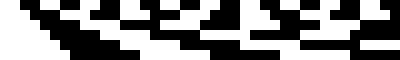

In [3]:
from typing import TypeAlias
from PIL import Image


Pixel: TypeAlias = bool


def race_the_beam(instructions: Iterable[str]) -> Iterator[Pixel]:
    register_x = accumulate(execute_video_instructions(instructions))
    next(register_x)  # make zero-based
    for cycle, x in enumerate(register_x):
        pos = cycle % 40
        yield pos - 1 <= x <= pos + 1


def crt_ascii_output(instructions: Iterable[str]) -> str:
    buffer = ["#" if pixel else "." for pixel in islice(race_the_beam(instructions), 240)]
    return "\n".join("".join(buffer[i : i + 40]) for i in range(0, len(buffer), 40))


assert (
    crt_ascii_output(large_example)
    == """\
##..##..##..##..##..##..##..##..##..##..
###...###...###...###...###...###...###.
####....####....####....####....####....
#####.....#####.....#####.....#####.....
######......######......######......####
#######.......#######.......#######.....\
"""
)


def crt_image_output(instructions: Iterable[str], scale: int = 10) -> Image:
    def to_bytes() -> Iterator[int]:
        value = 0
        for i, bit in enumerate(islice(race_the_beam(instructions), 240)):
            value = (value << 1) | int(bit)
            if i % 8 == 7:
                yield value
                value = 0
    
    data = bytes(to_bytes())
    img = Image.frombytes("1", (40, 6), data)
    return img.resize((img.size[0] * scale, img.size[1] * scale))

crt_image_output(large_example)

Part 2:


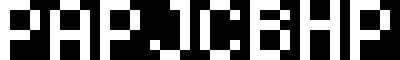

In [4]:
print("Part 2:")

crt_image_output(instructions)